# Interactive Spatial Autocorrelation

<center>
*"Everything is related to everything else, but near things are more related than distant things"*
</center>
<small>
<div style="text-align:right">
Waldo Tobler (1970)
</div>
</small>

* [Dani Arribas-Bel](http://darribas.org) ([@darribas](http://twitter.com/darribas))

In [1]:
# If you are running this notebook interactively, please run 
# all of the other cells before attempting to play with the
# interactive version
%matplotlib inline

import seaborn as sns
import pysal as ps
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv

## Spatial autocorrelation

Spatial autocorrelation has to do with the degree to which the similarity in values between observations in a dataset is related to the similarity in locations of such observations. Not completely unlike the traditional correlation between two variables -which informs us about how the values in one variable change as a function of those in the other- and analogous to its time-series counterpart -which relates the value of a variable at a given point in time with those in previous periods-, spatial autocorrelation relates the value of the variable of interest in a given location, with values of the same variable in surrounding locations.

A key idea in this context is that of *spatial randomness*: a situation in which the location of an observation gives no information whatsoever about its value. In other words, a variable is spatially random if it is distributed following no discernible pattern over space. Spatial autocorrelation can thus be formally defined as the "absence of spatial randomness", which gives room for two main classes of autocorrelation, similar to the traditional case:

* **Positive** spatial autocorrelation: similar values tend to group together in similar locations.
* **Negative** spatial autocorrelation: similar values tend to be dispersed and further apart from each other.

This notebook illustrates the concept using some of the widgets available in the Jupyter Notebook. Thanks to the interactivity they afford, it is possible to modify the degree of spatial autocorrelation embedded in a synthetic variable that is generated, mapped, and displayed in the so called Moran Plot.

## Interactive example

Executing the following code cell sets up an interactive exploration of spatial autocorrelation. You can modify the value in the horizontal slider to control how spatially correlated the resulting map will be: 0 implies complete spatial randomness; 0.9 is a high degree of positive spatial autocorrelation; and -0.9 represents extremely high negative spatial autocorrelation.

Once you have selected a value for the `lamb` parameter, the visualization returns two figures:

* On the left hand side, you can see a lattice map representing the location of each observation and the value assigned to each of them encoded in a color gradient ranging from light yellow (lowest) to dark green (highest).
* On the right hand side, you can see the Moran Plot for the dataset generated. This is a graphical device that displays the values of a variable in each location (X axis) against its "spatial lag", that is, the average value in the "neighborhood" of each observation.

Go ahead and play with setting different degrees of spatial autocorrelation in the underlying data:

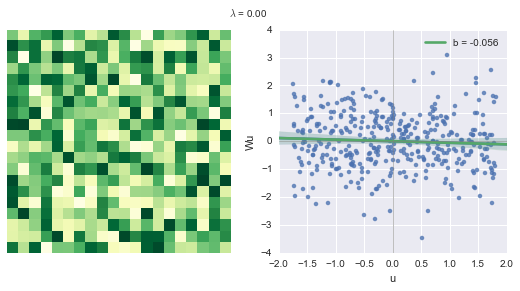

In [4]:
# IMPORTANT! To run this cell you first need to run the 
# cell that defines the function `draw_map`, which you can
# find below on the section "Code geek version"
from ipywidgets import interact
_ = interact(draw_map, lamb=(-0.9, 0.9))

How does the value set for `lamb` affect the pattern in the map on the left?

How does the Moran Plot change as the map becomes more or less clustered?

## "Math geek" explanation

The data generating process (DGP) considered to create the sythetic dataset here is the following:

$u = \lambda Wu + \epsilon$

Where $u$ is a vector spatially autocorrelated, $W$ is a spatial weights matrix as you could created with `PySAL`, and $\epsilon$ is an i.i.d. random vector.

We can rearrange terms to express $u$ as a function of $\epsilon$, which we can easily generate as a random noise:

1. $u - \lambda Wu = \epsilon$

1. $u (I - \lambda W) = \epsilon$

1. $u = (I - \lambda W)^{-1} \epsilon$

And this will give us, from a vector or randomly generated values, a particular $W$, and a pre-set $\lambda$, a vector of spatially autocorrelated values that we can plot both on a gridded map, and on a simple Moran Scatterplot. In this example, since we are using a perfect grid, we use a classic rook contiguity spatial weights matrix.

## "Code geek" explanation

To implement this DGP, we can write a method we will call `draw_map` that creates a random vector, transforms it into a spatially correlated variable with streength of $\lambda$, and allocates it into a lattice geography, where every pixel is assumed to be an area with a value. Right next to it, the code also displays the Moran's scatter plot. Both map and plot depend on the $\lambda$ parameter that controls the degree of spatial autocorrelation.

Here's the function:

In [2]:
def draw_map(lamb):
    '''
    Draw a map with a synthetic variable generated from 
    a spatially autoregressive GDP of strength `lamb`
    
    ...
    
    Arguments
    ---------
    lamb     : float
               Strength of the SAR process that generates 
               the sythetic data to map
    
    Returns
    -------
    None
    '''
    s = 20
    n = s**2
    w = ps.lat2W(s, s, rook=False)
    w.transform = 'R'
    e = np.random.random((n, 1))
    u = inv(np.eye(n) - lamb * w.full()[0])
    u = np.dot(u, e)
    ul = ps.lag_spatial(w, u)
    u = (u - u.mean()) / np.std(u)
    ul = (ul - ul.mean()) / np.std(ul)
    gu = u.reshape((s, s))
    # Figure
    f = plt.figure(figsize=(9, 4))
    ax1 = f.add_subplot(121)
    ax1.matshow(gu, cmap=plt.cm.YlGn)
    ax1.set_frame_on(False)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    #---
    ax2 = f.add_subplot(122)
    ols = ps.spreg.OLS(ul, u)
    tag = "b = %.3f"%ols.betas[1][0]
    sc = sns.regplot(u.ravel(), ul.ravel(), ax=ax2)
    sc = sns.regplot(u.ravel(), ul.ravel(), ax=ax2, \
                     scatter=False, label=tag)
    ax2.axvline(0, c='0.5', linewidth=0.5)
    ax2.axhline(0, c='0.5', linewidth=0.5)
    ax2.legend()
    plt.xlabel('u')
    plt.ylabel('Wu')
    plt.suptitle("$\lambda$ = %.2f"%lamb)
    plt.show()
    return None

And here is a simple, static run of the function for a value of $\lambda = 0.95$:

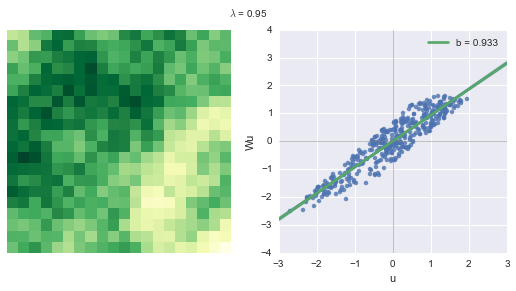

In [3]:
draw_map(0.95)

## License

**NOTE**: this notebook is a modified version of [this other one](http://nbviewer.ipython.org/gist/darribas/9943372) and it's stored as a Github repository on the following address:

> [https://github.com/darribas/int_sp_auto](https://github.com/darribas/int_sp_auto)

A static HTML version can be found [here](http://nbviewer.ipython.org/github/darribas/int_sp_auto/blob/master/index.ipynb).

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img
alt="Creative Commons License" style="border-width:0"
src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br /><span
xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Binder notebook for interactive spatial autocorrelation</span> by <a xmlns:cc="http://creativecommons.org/ns#"
href="http://darribas.org" property="cc:attributionName"
rel="cc:attributionURL">Dani Arribas-Bel</a> is licensed under a <a rel="license"
href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons
Attribution-NonCommercial-ShareAlike 4.0 International License</a>